In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import csv
import torch, argparse
import autograd.numpy as np
import autograd

from scipy.stats import norm
from utils import leapfrog, to_pickle, from_pickle
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm
from scipy.stats import uniform

2025-01-09 17:57:24.099191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
input_dim = 2
len_sample = 20
num_samples = 20
test_fraction = 0
timescale = 0.05

In [3]:
def H(coords):
    #coords = [q,p] in R2
    q, p = np.split(coords,2)
    mu1 = 1.0
    mu2 =-1.0
    sigma = 0.35
    term1 = -np.log(0.5*(np.exp(-(q-mu1)**2/(2*sigma**2)))+0.5*(np.exp(-(q-mu2)**2/(2*sigma**2))))
    H_val = term1 + p**2/2 # Normal PDF
    return H_val 

In [4]:
def dynamics_fn(t, coords):
    dcoords = autograd.grad(H)(coords)
    dic1 = np.split(dcoords,input_dim)
    S = np.concatenate([dic1[int(input_dim/2)]])
    for ii in np.arange(int(input_dim/2)+1,input_dim,1):
        S = np.concatenate([S, dic1[ii]])
    for ii in np.arange(0,int(input_dim/2),1):
        S = np.concatenate([S, -dic1[ii]])
    return S

def get_trajectory(t_span=[0,len_sample], timescale=timescale, y0=None, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1]-t_span[0])/timescale))

    if y0 is None:
        y0 = np.zeros(input_dim)
        for ii in np.arange(0,int(input_dim/2),1):
            y0[ii] = norm(loc=0,scale=1).rvs()
    #lp_ivp = leapfrog(dynamics_fn, t_span, y0,int(timescale*(t_span[1]-t_span[0])), input_dim)
    lp_ivp = leapfrog(dynamics_fn, t_span, y0,int((t_span[1]-t_span[0])/timescale), input_dim)
    dic1 = np.split(lp_ivp, input_dim)
    dydt = [dynamics_fn(None, lp_ivp[:,ii]) for ii in range(0, lp_ivp.shape[1])]
    dydt = np.stack(dydt).T
    ddic1 = np.split(dydt, input_dim)
    return dic1, ddic1, t_eval

In [5]:
def get_dataset(seed=0, samples=num_samples, test_split=(1.0-test_fraction), **kwargs):
    data = {'meta': locals()}
    # randomly sample inputs
    np.random.seed(seed) #
    xs, dxs = [], []
    index1 = 0

    count1 = 0
    y_init = np.zeros(input_dim)
    for ii in np.arange(0,int(input_dim/2),1):
        y_init[ii] = 0.0
    for ii in np.arange(int(input_dim/2),input_dim,1):
        y_init[ii] = norm(loc=0,scale=1).rvs()

    print('Generating HMC samples for HNN training')

    for s in range(samples):
        print('Sample number ' + str(s+1) + ' of ' + str(samples))
        dic1, ddic1, t = get_trajectory(y0=y_init,**kwargs)
        xs.append(np.stack( [dic1[ii].T.reshape(len(dic1[ii].T)) for ii in np.arange(0,input_dim,1)]).T)
        dxs.append(np.stack( [ddic1[ii].T.reshape(len(ddic1[ii].T)) for ii in np.arange(0,input_dim,1)]).T)
        y_init = np.zeros(input_dim)
        count1 = count1 + 1
        #print(dic1[0].shape)
        for ii in np.arange(0,int(input_dim/2),1):
            y_init[ii] = dic1[ii][0,-1]
        for ii in np.arange(int(input_dim/2),input_dim,1):
            y_init[ii] = norm(loc=0,scale=1).rvs()

    data['coords'] = np.concatenate(xs)
    data['dcoords'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['coords']) * test_split)
    split_data = {}
    for k in ['coords', 'dcoords']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data

    # save data
    path = "./data"
    if not os.path.exists(path):
        os.makedirs(path)
    to_pickle(data, path+"/{}.pkl".format("1DGaussian"))

    return data

In [6]:
dat = get_dataset()

Generating HMC samples for HNN training
Sample number 1 of 20
Sample number 2 of 20
Sample number 3 of 20
Sample number 4 of 20
Sample number 5 of 20
Sample number 6 of 20
Sample number 7 of 20
Sample number 8 of 20
Sample number 9 of 20
Sample number 10 of 20
Sample number 11 of 20
Sample number 12 of 20
Sample number 13 of 20
Sample number 14 of 20
Sample number 15 of 20
Sample number 16 of 20
Sample number 17 of 20
Sample number 18 of 20
Sample number 19 of 20
Sample number 20 of 20


In [7]:
dat['coords'].shape,dat['dcoords'].shape

((8020, 2), (8020, 2))

In [8]:
dat["dcoords"]

array([[ 1.76405235, -0.        ],
       [ 1.87195437,  4.31608098],
       [ 2.12738862,  5.90128914],
       ...,
       [-1.26356053, -2.97798555],
       [-1.39881515, -2.43219933],
       [-1.50553403, -1.83655565]])

In [9]:
import matplotlib.pyplot as plt 

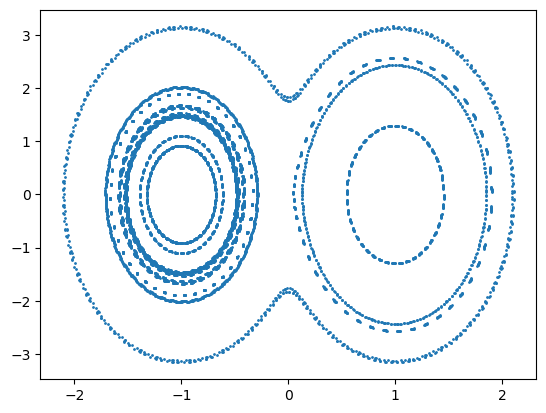

In [10]:
plt.scatter(dat['coords'][:,0],dat['coords'][:,1],s=1)

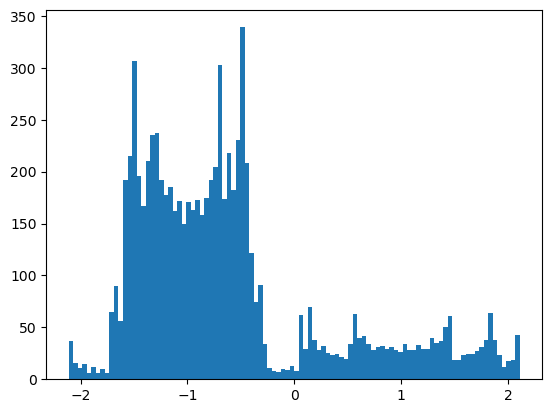

In [11]:
plt.hist(dat['coords'][:,0],bins=100)
plt.show()

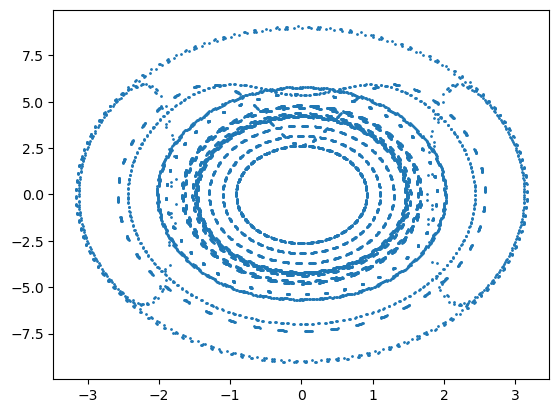

In [12]:
plt.scatter(dat['dcoords'][:,0],dat['dcoords'][:,1],s=1)

In [13]:
# Define the L-HNN model
class L_HNN(tf.keras.Model):
    def __init__(self):
        super(L_HNN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(100, activation='relu') for _ in range(3)]
        self.output_layer = tf.keras.layers.Dense(input_dim)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

    def build(self,input_shape):
        self.hidden_layers[0].build(input_shape)
        input_shape = self.hidden_layers[0].compute_output_shape(input_shape)
        for layer in self.hidden_layers[1:]:
            layer.build(input_shape)
            input_shape = layer.compute_output_shape(input_shape)
        self.output_layer.build(input_shape)
        self.built = True


class HNN(tf.keras.Model):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.assume_canonical_coords = assume_canonical_coords
        self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        self.field_type = field_type

    def call(self, x):
        # traditional forward pass
        if self.baseline:
            return self.differentiable_model(x)

        y = self.differentiable_model(x)
        assert len(y.shape) == 2 and y.shape[1] == input_dim, "Output tensor should have shape [batch_size, 2]"
        answer1 = tf.split(y,2,axis=1) # is it correct?
        return answer1

    #def lfrog_time_derivative(self, x, dt):
    #    return lfrog(fun=self.time_derivative, y0=x, t=0, dt=dt)

    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''

        conservative_field = tf.zeros_like(x) # start out with both components set to 0
        solenoidal_field = tf.zeros_like(x)

        with tf.GradientTape() as tape:
            tape.watch(x)
            F1, F2 = self.call(x) # traditional forward pass
            # notion: here autograd is a pytorch function, we change it to tf autograd
            if self.field_type != 'solenoidal':
                F1 = tf.reduce_sum(F1)
                
                dF1 = tape.gradient(F1, x)
                conservative_field = dF1 @ tf.eye(*self.M.shape)

            if self.field_type != 'conservative':
                F2 = tf.reduce_sum(F2)
                dF2 = tape.gradient(F2, x)
                solenoidal_field = dF2 @ tf.transpose(self.M)

        if separate_fields:
            return [conservative_field, solenoidal_field]

        return conservative_field + solenoidal_field

    def permutation_tensor(self,n):
        M = None
        if self.assume_canonical_coords:
            M = tf.eye(n)
            M = tf.concat([M[n//2:], -M[:n//2]],axis=0)
        else:
            '''Constructs the Levi-Civita permutation tensor'''
            M = tf.ones(n,n) # matrix of ones
            M *= 1 - tf.eye(n) # clear diagonals
            M[::2] *= -1 # pattern of signs
            M[:,::2] *= -1

            for i in range(n): # make asymmetric
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M


# Training the L-HNN
def train_l_hnn(coords,dcoords, epochs=3000):
    model_hnn = L_HNN()
    model_hnn.build(input_shape=(None, 2))
    model = HNN(input_dim, model_hnn, field_type='solenoidal', baseline=False, assume_canonical_coords=True)
    

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    num_trainable_params = np.sum([np.prod(var.shape) for var in model.trainable_variables])
    print(f'Number of gradients to be calculated for L-HNN: {num_trainable_params}')

    coords = tf.convert_to_tensor(coords, dtype=tf.float32)
    dcoords = tf.convert_to_tensor(dcoords, dtype=tf.float32)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape2:
                tape2.watch(coords)
                H = model(coords)

                divH = tape2.gradient(H, coords)
                H_q =  divH[:,0]
                H_p =  divH[:,1]

            loss = tf.reduce_mean(tf.square(H_p - dcoords[:,0])) + tf.reduce_mean(tf.square(-H_q - dcoords[:,1]))
            grads = tape.gradient(loss, model.trainable_variables)

            if grads is None or all(g is None for g in grads):
                print(f"No gradients computed at epoch {epoch}. Skipping update.")
                continue  # Skip update if no gradients are computed

            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.numpy()}')

            if epoch % 1000 == 0:
                model.differentiable_model.save_weights("./models/L_HNN.weights.h5")
    
    return model

In [16]:
model = train_l_hnn(dat['coords'],dat['dcoords'])

Number of gradients to be calculated for L-HNN: 20702
Epoch 0, Loss: 15.233819961547852
Epoch 100, Loss: 13.58804702758789
Epoch 200, Loss: 11.488572120666504
Epoch 300, Loss: 10.714287757873535
Epoch 400, Loss: 10.282903671264648
Epoch 500, Loss: 10.022917747497559
Epoch 600, Loss: 10.059419631958008
Epoch 700, Loss: 10.032273292541504
Epoch 800, Loss: 9.986496925354004
Epoch 900, Loss: 9.94749927520752


In [17]:
model_ = L_HNN()
model_.build(input_shape=(None, 2))
model_.load_weights("./models/L_HNN.weights.h5")
model = HNN(input_dim=input_dim, differentiable_model=model_, field_type='solenoidal', baseline=False, assume_canonical_coords=True)


In [31]:
chains = 1 # number of Markov chains
N = 5000 # number of samples   
L = 10 # length of each hamiltonian trajectory
burn = 20 # burn-in samples
epsilon = 0.025 # step for time integration

In [32]:
def integrate_model(model, t_span, y0, n, **kwargs):
    def fun(t, np_x):
        #x = tf.convert_to_tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,input_dim)
        x = tf.convert_to_tensor(np_x.reshape(-1,input_dim), dtype=tf.float32)
        dx = model.time_derivative(x).numpy().reshape(-1)
        return dx
    return leapfrog(fun, t_span, y0, n, input_dim)

In [33]:
steps = L*int(1/epsilon)
t_span = [0,L]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], steps), 'rtol': 1e-10}
hnn_fin = np.zeros((chains,N,int(input_dim/2)))
hnn_accept = np.zeros((chains,N))

y0 = np.zeros(input_dim)
for ss in np.arange(0,chains,1):
    x_req = np.zeros((N,int(input_dim/2)))
    x_req[0,:] = y0[0:int(input_dim/2)]
    accept = np.zeros(N)
    
    for ii in np.arange(0,int(input_dim/2),1):
        y0[ii] = 0.0
    for ii in np.arange(int(input_dim/2),int(input_dim),1):
        y0[ii] = norm(loc=0,scale=1).rvs()
    HNN_sto = np.zeros((input_dim,steps,N))
    for ii in np.arange(0,N,1):
        hnn_ivp = integrate_model(model, t_span, y0, steps-1, **kwargs)
        #hnn_ivp = leapfrog(dynamics_fn, t_span, y0, steps-1, input_dim)
        for sss in range(0,input_dim):
            HNN_sto[sss,:,ii] = hnn_ivp[sss,:]
        yhamil = np.zeros(input_dim)
        for jj in np.arange(0,input_dim,1):
            yhamil[jj] = hnn_ivp[jj,steps-1]
        H_star = H(yhamil)
        H_prev = H(y0)
        alpha = np.minimum(1,np.exp(H_prev - H_star))
        if alpha > uniform().rvs():
            y0[0:int(input_dim/2)] = hnn_ivp[0:int(input_dim/2),steps-1]
            x_req[ii,:] = hnn_ivp[0:int(input_dim/2),steps-1]
            accept[ii] = 1
        else:
            x_req[ii,:] = y0[0:int(input_dim/2)]
        for jj in np.arange(int(input_dim/2),input_dim,1):
            y0[jj] = norm(loc=0,scale=1).rvs()
        print("Sample: "+str(ii)+" Chain: "+str(ss))
    hnn_accept[ss,:] = accept
    hnn_fin[ss,:,:] = x_req

ess_hnn = np.zeros((chains,int(input_dim/2)))
for ss in np.arange(0,chains,1):
    hnn_tf = tf.convert_to_tensor(hnn_fin[ss,burn:N,:])
    ess_hnn[ss,:] = np.array(tfp.mcmc.effective_sample_size(hnn_tf))

Sample: 0 Chain: 0
Sample: 1 Chain: 0
Sample: 2 Chain: 0
Sample: 3 Chain: 0
Sample: 4 Chain: 0
Sample: 5 Chain: 0
Sample: 6 Chain: 0
Sample: 7 Chain: 0
Sample: 8 Chain: 0
Sample: 9 Chain: 0
Sample: 10 Chain: 0
Sample: 11 Chain: 0
Sample: 12 Chain: 0
Sample: 13 Chain: 0
Sample: 14 Chain: 0
Sample: 15 Chain: 0
Sample: 16 Chain: 0
Sample: 17 Chain: 0
Sample: 18 Chain: 0
Sample: 19 Chain: 0
Sample: 20 Chain: 0
Sample: 21 Chain: 0
Sample: 22 Chain: 0
Sample: 23 Chain: 0
Sample: 24 Chain: 0
Sample: 25 Chain: 0
Sample: 26 Chain: 0
Sample: 27 Chain: 0
Sample: 28 Chain: 0
Sample: 29 Chain: 0
Sample: 30 Chain: 0
Sample: 31 Chain: 0
Sample: 32 Chain: 0
Sample: 33 Chain: 0
Sample: 34 Chain: 0
Sample: 35 Chain: 0
Sample: 36 Chain: 0
Sample: 37 Chain: 0
Sample: 38 Chain: 0
Sample: 39 Chain: 0
Sample: 40 Chain: 0
Sample: 41 Chain: 0
Sample: 42 Chain: 0
Sample: 43 Chain: 0
Sample: 44 Chain: 0
Sample: 45 Chain: 0
Sample: 46 Chain: 0
Sample: 47 Chain: 0
Sample: 48 Chain: 0
Sample: 49 Chain: 0
Sample: 50

In [27]:
for ss in np.arange(0,chains,1):
    subdat = hnn_fin[ss,burn:N,:]
    subacc = hnn_accept[ss,burn:N]

    accpt = subdat[subacc==1,:]
    

In [28]:
accpt.shape 

(42, 1)

(array([1., 0., 0., 1., 1., 1., 2., 2., 0., 0., 0., 1., 0., 0., 1., 2., 1.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 3., 1., 0., 0., 1.,
        1., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0., 1.]),
 array([-1.67895905, -1.64448888, -1.61001872, -1.57554856, -1.54107839,
        -1.50660823, -1.47213806, -1.4376679 , -1.40319774, -1.36872757,
        -1.33425741, -1.29978724, -1.26531708, -1.23084692, -1.19637675,
        -1.16190659, -1.12743642, -1.09296626, -1.0584961 , -1.02402593,
        -0.98955577, -0.9550856 , -0.92061544, -0.88614528, -0.85167511,
        -0.81720495, -0.78273478, -0.74826462, -0.71379446, -0.67932429,
        -0.64485413, -0.61038396, -0.5759138 , -0.54144364, -0.50697347,
        -0.47250331, -0.43803314, -0.40

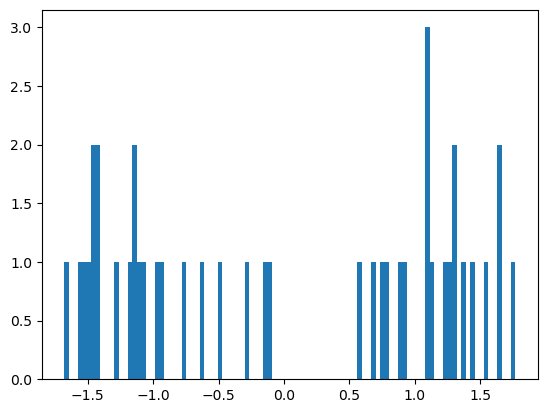

In [29]:
plt.hist(accpt,bins=100)